# CS515 Homework 3: Transfer Learning - Starter Notebook

**Overview:**  
In this assignment, we will implement a transfer learning approach using **PyTorch** and **AlexNet** on the **CelebA-HQ 30k** dataset for **gender classification**.


## 1. Setup and Imports
We import primary packages (PyTorch, torchvision, etc.). In addition, we will install the Hugging Face `datasets` library to download CelebA-HQ.

In [2]:
!pip install -q datasets

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np
import itertools
from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import os
from datasets import load_dataset, concatenate_datasets

torch.manual_seed(42)
np.random.seed(42)

# Make sure to switch the runtime device to GPU in Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2. Data Loading and Transformation
We will load the dataset from the Hugging Face hub. The dataset is labeled with multiple attributes, including `Gender`.

In [4]:
# Load the Celeba-hq dataset from Hugging Face
dataset = load_dataset("mattymchen/celeba-hq")
temp_dataset = dataset['train'].train_test_split(test_size=2000)
dataset['train'] = temp_dataset['train']
dataset['test'] = temp_dataset['test']
del temp_dataset

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 26000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})


## 3. PyTorch Dataset and Dataloaders
We'll create a PyTorch `Dataset` class that:
- Takes a Hugging Face dataset sample (which contains `image` and `label`).
- Applies the transforms (resize to 224x224, convert to tensor, normalize by ImageNet stats).
- Returns `(image, label)`.

We then wrap it in a PyTorch `DataLoader` for training/validation/testing.


In [5]:
class CelebAHQDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.data = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image']

        # The correct key for the label is "label"
        label = int(sample['label'])

        if self.transform:
            image = self.transform(image)

        return image, label

### Define Transforms and Create Loaders
We use standard ImageNet stats for normalization.

mean = [0.485, 0.456, 0.406] \
std = [0.229, 0.224, 0.225]

**DataLoaders** - we'll select batch size of 512. We shuffle for train but not necessarily for validation and test.


In [6]:
# ImageNet statistics
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Define the transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create Dataset objects
train_dataset = CelebAHQDataset(dataset['train'], transform=transform_pipeline)
val_dataset   = CelebAHQDataset(dataset['validation'], transform=transform_pipeline)
test_dataset  = CelebAHQDataset(dataset['test'], transform=transform_pipeline)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Val Dataset size:   {len(val_dataset)}")
print(f"Test Dataset size:  {len(test_dataset)}")

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Train Dataset size: 26000
Val Dataset size:   2000
Test Dataset size:  2000
Number of training batches: 51
Number of validation batches: 4
Number of test batches: 4


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Creating AlexNet Models

1. Random Initialization
2. Transfer Learning w. Pre-trained Network
3. Fine-tuning Learning w. Pre-trained Network

**Note:** AlexNet can be loaded from torchvision with _models.alexnet(pretrained=)

**Advise:** Because you need to re-create the models for different part of the homework, it's always good to create a function that will return a new model.

In [7]:
def create_alexnet(model_type='random', num_classes=2):
    """
    model_type: 'random', 'transfer', or 'fine_tune'
    num_classes: e.g., 2 (for male/female)
    """
    if model_type == 'random':
        # Randomly initialized
        model = models.alexnet(pretrained=False)
    else:
        # Transfer or fine-tune
        model = models.alexnet(pretrained=True)

    # Replace last Linear layer in classifier
    # AlexNet's classifier is [Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear]
    # The last layer index is 6 in model.classifier
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)

    if model_type == 'transfer':
        # Freeze all parameters except the last layer
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the newly added layer
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    elif model_type == 'fine_tune':
        # Freeze all parameters initially
        for param in model.parameters():
            param.requires_grad = False
        # Unfreeze the last FC layer (classifier[4]) and the final layer (classifier[6])
        for param in model.classifier[4].parameters():
            param.requires_grad = True
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    # Print number of trainable vs total params
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model Type: {model_type} | Trainable: {trainable_params} / Total: {total_params}")

    model = model.to(device)
    return model

## 5. Hyperparameter Tuning
We'll do a small loop over LR candidates, train for 15 steps on the training set, measure validation accuracy, and pick the best LR for each model. Use Cross Entropy as the loss function and Adam as the optimizer.

**LR candidates:** [1e-5, 1e-4, 1e-3]

In [8]:
def tune_lr_for_model(model_type):
    lr_candidates = [1e-5, 1e-4, 1e-3]
    best_lr = None
    best_val_acc = 0.0

    for lr in lr_candidates:
        print(f"\nTesting {model_type} with lr={lr}")
        # Create a fresh model for each LR
        model = create_alexnet(model_type=model_type, num_classes=2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Train for 15 steps only
        model.train()
        steps = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            steps += 1
            if steps >= 15:
                break

        # Evaluate on validation set
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        val_acc = accuracy_score(all_labels, all_preds)
        print(f"Validation Accuracy = {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr

    print(f"\nBest LR for {model_type} = {best_lr} with val_acc={best_val_acc:.4f}")
    return best_lr

## 6. Final Training and Evaluation
Once we have the best LR for each model, we'll combine train+val sets to create a bigger training set, then retrain using the optimal Learning Rate and Optimizer.
We’ll do 3 epochs, then evaluate on the test set. You can follow these steps:

1. Recreate the model.
2. Use the best learning rate for that model.
5. Use Cross Entropy as the loss function and Adam as the Optimizer
4. Train for 3 epochs on the combined train set.

In [9]:
# Combine the train and validation splits for final training
dataset['train'] = concatenate_datasets([dataset['train'], dataset['validation']])
full_train_dataset = CelebAHQDataset(dataset['train'], transform=transform_pipeline)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print("Combined Train+Val set size:", len(full_train_dataset))


Combined Train+Val set size: 28000


### 6.1 Final Training for Random Model

In [10]:
def final_train_evaluate(model_type, best_lr, epochs=3):
    model = create_alexnet(model_type=model_type, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)

    train_losses = []
    train_accuracies = []

    # Training Loop
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        epoch_loss = 0.0
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = epoch_loss / len(full_train_loader)
        train_acc = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        print(f"[{model_type}] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {train_acc:.4f}")

    # Evaluate on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc  = accuracy_score(all_labels, all_preds)
    test_prec = precision_score(all_labels, all_preds, average='weighted')
    test_rec  = recall_score(all_labels, all_preds, average='weighted')
    test_f1   = f1_score(all_labels, all_preds, average='weighted')
    cm        = confusion_matrix(all_labels, all_preds)

    print(f"\nFinal Test Results ({model_type}):")
    print(f" Accuracy:  {test_acc:.4f}")
    print(f" Precision: {test_prec:.4f}")
    print(f" Recall:    {test_rec:.4f}")
    print(f" F1-Score:  {test_f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return model, train_losses, train_accuracies, (test_acc, test_prec, test_rec, test_f1), cm

# Example usage for random model
best_lr_random = tune_lr_for_model("random")
model_random, losses_random, accs_random, metrics_random, cm_random = final_train_evaluate("random", best_lr_random, epochs=3)


Testing random with lr=1e-05


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Type: random | Trainable: 57012034 / Total: 57012034
Validation Accuracy = 0.5000

Testing random with lr=0.0001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Type: random | Trainable: 57012034 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.5000

Testing random with lr=0.001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Type: random | Trainable: 57012034 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.5000

Best LR for random = 1e-05 with val_acc=0.5000


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model Type: random | Trainable: 57012034 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[random] Epoch 1/3 - Loss: 0.6525, Acc: 0.6310
[random] Epoch 2/3 - Loss: 0.5453, Acc: 0.7197
[random] Epoch 3/3 - Loss: 0.4414, Acc: 0.7978

Final Test Results (random):
 Accuracy:  0.8365
 Precision: 0.8441
 Recall:    0.8365
 F1-Score:  0.8384
Confusion Matrix:
[[1065  211]
 [ 116  608]]


In [11]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>,
 'label': 0}

### 6.2 Final Training for Transfer Learning w. Pre-trained Network:

In [12]:
best_lr_transfer = tune_lr_for_model("transfer")
model_transfer, losses_transfer, accs_transfer, metrics_transfer, cm_transfer = \
    final_train_evaluate("transfer", best_lr_transfer, epochs=3)


Testing transfer with lr=1e-05


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 61.9MB/s]


Model Type: transfer | Trainable: 8194 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.5245

Testing transfer with lr=0.0001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: transfer | Trainable: 8194 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.7225

Testing transfer with lr=0.001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: transfer | Trainable: 8194 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.8595

Best LR for transfer = 0.001 with val_acc=0.8595


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: transfer | Trainable: 8194 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[transfer] Epoch 1/3 - Loss: 0.2975, Acc: 0.8719
[transfer] Epoch 2/3 - Loss: 0.2251, Acc: 0.9085
[transfer] Epoch 3/3 - Loss: 0.2116, Acc: 0.9136

Final Test Results (transfer):
 Accuracy:  0.9180
 Precision: 0.9177
 Recall:    0.9180
 F1-Score:  0.9178
Confusion Matrix:
[[1202   74]
 [  90  634]]


### 6.3 Fine-tuning Learning w. Pre-trained Network:

In [13]:
best_lr_finetune = tune_lr_for_model("fine_tune")
model_finetune, losses_finetune, accs_finetune, metrics_finetune, cm_finetune = \
    final_train_evaluate("fine_tune", best_lr_finetune, epochs=3)


Testing fine_tune with lr=1e-05


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: fine_tune | Trainable: 16789506 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.7435

Testing fine_tune with lr=0.0001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: fine_tune | Trainable: 16789506 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.9115

Testing fine_tune with lr=0.001


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: fine_tune | Trainable: 16789506 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation Accuracy = 0.9320

Best LR for fine_tune = 0.001 with val_acc=0.9320


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model Type: fine_tune | Trainable: 16789506 / Total: 57012034


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[fine_tune] Epoch 1/3 - Loss: 0.3196, Acc: 0.8890
[fine_tune] Epoch 2/3 - Loss: 0.1721, Acc: 0.9313
[fine_tune] Epoch 3/3 - Loss: 0.1576, Acc: 0.9367

Final Test Results (fine_tune):
 Accuracy:  0.9430
 Precision: 0.9429
 Recall:    0.9430
 F1-Score:  0.9428
Confusion Matrix:
[[1232   44]
 [  70  654]]


### 6.3 Plot Training Loss and Accuracy Curves
We only used a single (train) set in the final stage, but we can still visualize how the training accuracy evolves across epochs for both models.

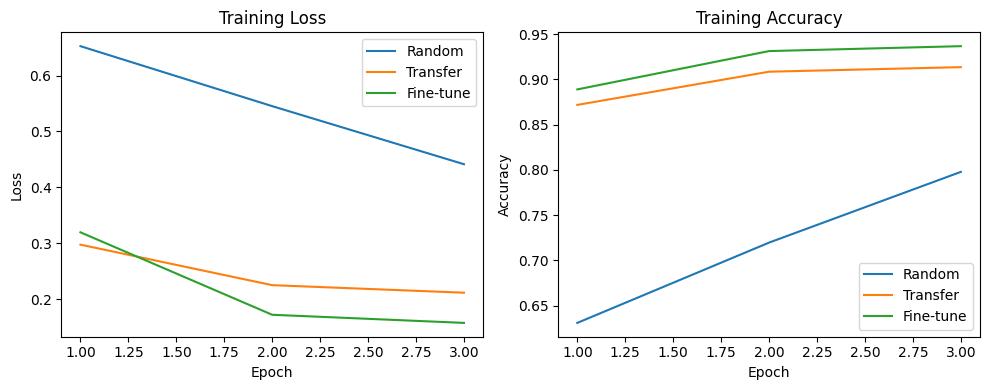

In [14]:
epochs_array = range(1, 4)  # for 3 epochs

plt.figure(figsize=(10,4))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(epochs_array, losses_random,   label='Random')
plt.plot(epochs_array, losses_transfer, label='Transfer')
plt.plot(epochs_array, losses_finetune, label='Fine-tune')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_array, accs_random,   label='Random')
plt.plot(epochs_array, accs_transfer, label='Transfer')
plt.plot(epochs_array, accs_finetune, label='Fine-tune')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### 6.4 Evaluation on Test Set (this part is handled inside of the loop)


### 6.5 Visualizing Misclassified Examples
Randomly pick 5 test samples that were classified **incorrectly** for the best performing model, and display them with the predicted vs. true labels. This helps us see what types of mistakes the model makes.

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


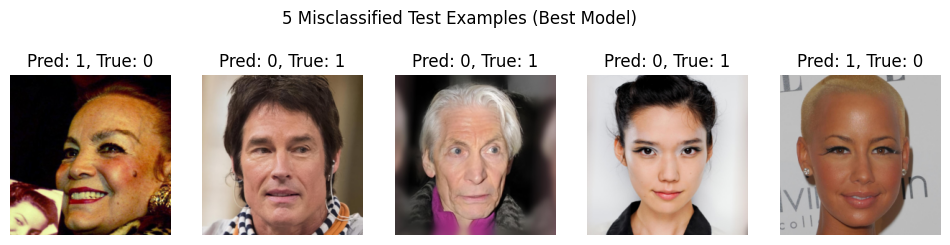

In [15]:
# Suppose we want to see misclassifications from the best performing model
model_best = model_finetune

model_best.eval()
misclassified_imgs = []
misclassified_preds = []
misclassified_trues = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        preds = outputs.argmax(dim=1)
        for i in range(len(labels)):
            if preds[i] != labels[i] and len(misclassified_imgs) < 5:
                misclassified_imgs.append(images[i].cpu())
                misclassified_preds.append(preds[i].cpu().item())
                misclassified_trues.append(labels[i].cpu().item())
        if len(misclassified_imgs) >= 5:
            break

# Denormalize for display
def denormalize(img_tensor):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

# Plot the 5 misclassified images
plt.figure(figsize=(12,3))
for idx, img in enumerate(misclassified_imgs):
    img_dn = denormalize(img).permute(1,2,0).numpy()
    plt.subplot(1,5,idx+1)
    plt.imshow(img_dn)
    plt.title(f"Pred: {misclassified_preds[idx]}, True: {misclassified_trues[idx]}")
    plt.axis("off")
plt.suptitle("5 Misclassified Test Examples (Best Model)")
plt.show()

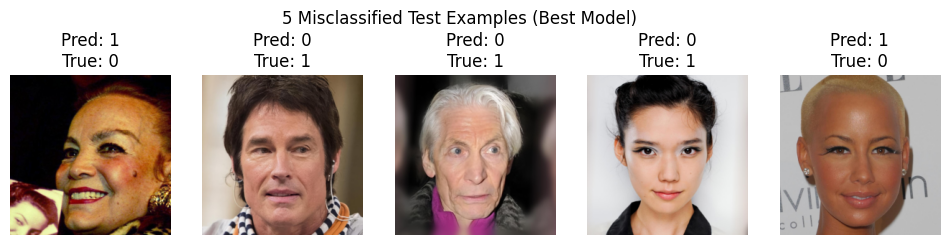

In [18]:
model_best = model_finetune
model_best.eval()
misclassified_images = []
misclassified_preds = []
misclassified_labels = []
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_best(images)
        preds = outputs.argmax(dim=1)
        # Find misclassified indices
        for i in range(len(labels)):
            if preds[i] != labels[i] and len(misclassified_images) < 5:
                misclassified_images.append(images[i].cpu())
                misclassified_preds.append(preds[i].cpu().item())
                misclassified_labels.append(labels[i].cpu().item())
        if len(misclassified_images) >= 5:
            break

if len(misclassified_images) == 0:
    print("No misclassified examples found.")
else:
    # Denormalize images for visualization
    def denormalize(img_tensor):
        img = img_tensor.clone()
        for t, m, s in zip(img, imagenet_mean, imagenet_std):
            t.mul_(s).add_(m)
        return img

    plt.figure(figsize=(12,3))
    for idx, img in enumerate(misclassified_images):
        img_denorm = denormalize(img).permute(1,2,0).numpy()
        plt.subplot(1,5,idx+1)
        plt.imshow(img_denorm)
        plt.title(f"Pred: {misclassified_preds[idx]}\nTrue: {misclassified_labels[idx]}")
        plt.axis('off')
    plt.suptitle("5 Misclassified Test Examples (Best Model)")
    plt.show()

In [ ]:
from collections import Counter
labels = [label for _, label in test_dataset]
print("Test label distribution:", Counter(labels))